In [2]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

In [1]:

from __future__ import print_function
import keras
from keras.models import Sequential
from keras import layers
from keras.datasets import mnist
from keras import backend as K


class Antirectifier(layers.Layer):
    '''This is the combination of a sample-wise
    L2 normalization with the concatenation of the
    positive part of the input with the negative part
    of the input. The result is a tensor of samples that are
    twice as large as the input samples.

    It can be used in place of a ReLU.

    # Input shape
        2D tensor of shape (samples, n)

    # Output shape
        2D tensor of shape (samples, 2*n)

    # Theoretical justification
        When applying ReLU, assuming that the distribution
        of the previous output is approximately centered around 0.,
        you are discarding half of your input. This is inefficient.

        Antirectifier allows to return all-positive outputs like ReLU,
        without discarding any data.

        Tests on MNIST show that Antirectifier allows to train networks
        with twice less parameters yet with comparable
        classification accuracy as an equivalent ReLU-based network.
    '''

    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 2  # only valid for 2D tensors
        shape[-1] *= 2
        return tuple(shape)

    def call(self, inputs):
        inputs -= K.mean(inputs, axis=1, keepdims=True)
        inputs = K.l2_normalize(inputs, axis=1)
        pos = K.relu(inputs)
        neg = K.relu(-inputs)
        return K.concatenate([pos, neg], axis=1)

# global parameters
batch_size = 128
num_classes = 10
epochs = 40

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# build the model
model = Sequential()
model.add(layers.Dense(256, input_shape=(784,)))
model.add(Antirectifier())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256))
model.add(Antirectifier())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(10))
model.add(layers.Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Using TensorFlow backend.


60000 train samples
10000 test samples


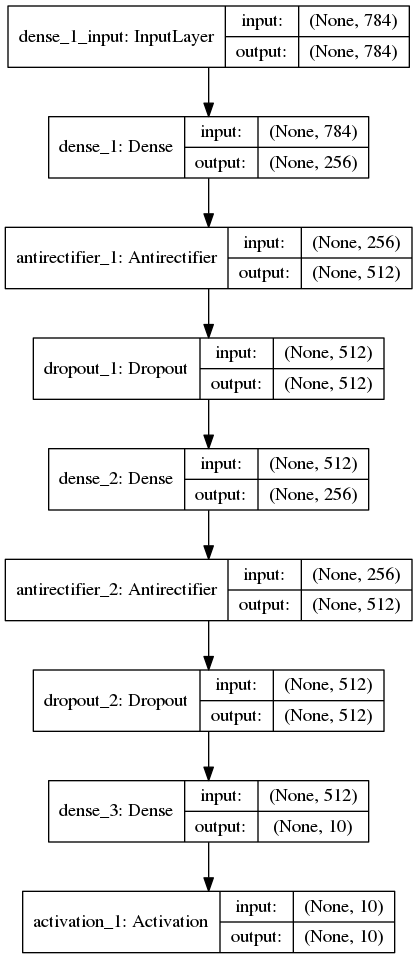

In [3]:
plot_model(model, to_file="antirectifier.png", show_shapes=True)
Image('antirectifier.png')